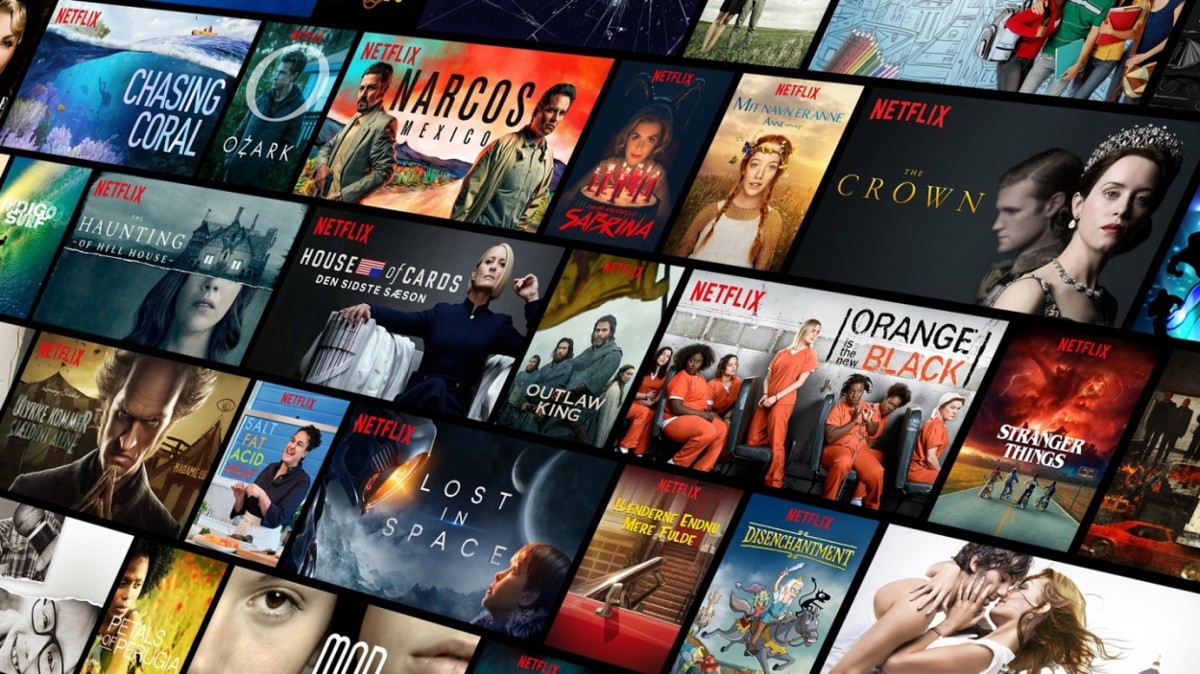

# <center>EDSA MOVIE RECOMMENDATION 2022</center>

Recommendation systems predict a user's rating or preference for an item. In this case, we are dealingn with movies from the MovieLens dataset. This recommendation system will predict what a given user will rate a movie. 

The algorithm in this notebook carries out its prediction based on similar content, or what is known as a content-based recommendation system. Given a movie that a user has not rated, the algorithm seeks to predict the rating based on the ratings given by the user on past movies. 

## Importing the data 

Explore Data Science Academy (EDSA) has provided us with 8 data files that will be used for predicting user's movie ratings. These data was resampled from the MovieLens dataset for fair evaluation. 

Our task in this section is to merge the files so as to extract the relevant properties from each file and create a dataframe that will be used in prediction. 

In [ ]:
# Importing the libraries we'll use 
import numpy as np
from numpy.linalg import norm
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline
#import squarify
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Entity featurization and similarity computation
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import (KNNBasic, Dataset,Reader,SVD,SVDpp, SlopeOne, NMF, 
                      NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans,
                      KNNWithZScore, BaselineOnly, CoClustering)
import re
import pickle
from surprise import accuracy, Dataset, SVD
import surprise
# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists
from datetime import datetime
# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


In [ ]:
#Run this code to install squarify if you haven't
#!pip install squarify
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 8.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633705 sha256=e66004b6d01f5d9f97bc4c60d48f294149c4d14e3473f87cf7a90c8a42fab582
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## Let's import the movies data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile('/content/drive/MyDrive/Copy of b.zip', 'r') as zipObj:
  zipObj.extractall('/content/drive/MyDrive/')

In [ ]:
movies_df = pd.read_csv('/content/drive/MyDrive/movies.csv')
tags_df = pd.read_csv('/content/drive/MyDrive/tags.csv')
imdb_df = pd.read_csv('/content/drive/MyDrive/imdb_data.csv')
movie_ratings = pd.read_csv('/content/drive/MyDrive/train.csv')
test= pd.read_csv('/content/drive/MyDrive/test.csv')
genomes_tags= pd.read_csv('/content/drive/MyDrive/genome_tags.csv')
genomes_score= pd.read_csv('/content/drive/MyDrive/genome_scores.csv')
links= pd.read_csv('/content/drive/MyDrive/links.csv')
submission= pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

In [ ]:
#movies_df = pd.read_csv('movies.csv')
movies_ratings= movie_ratings.copy() 

In [ ]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We can see that the genres properties, which is useful for our purposes, is separated by | character. We now remove the character to make it space delimited strings. 

In [ ]:
movies_df['genres'] = movies_df['genres'].str.split('|').str.join(',')

In [ ]:

movies_df.head(1)

,movieId,title,genres
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy"


## the tags data
We'll now take a look at the tags data

In [ ]:
#tags_df = pd.read_csv('tags.csv')

In [ ]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


From the above, we see that one user can tag a single movie more than once. We'll now examine if several users can tag the same movie

In [ ]:
# searching for user tags for movie id == 1
tags_df[tags_df['movieId'] == 1]

,userId,movieId,tag,timestamp
2306,791,1,Owned,1515175493
3749,1048,1,imdb top 250,1172144394
4226,1361,1,Pixar,1216146311
10003,3164,1,Pixar,1223304727
10004,3164,1,time travel,1223304729
...,...,...,...,...
1084685,160835,1,American Animation,1437092829
1084688,160858,1,computer animation,1451035426
1084689,160858,1,pixar,1451035426
1088052,161172,1,Pixar,1159534063


From the above, we can also see that several users can tag the same movie. 

So we need a way to collect all the tags for each movie and put them in the movies_df dataframe. We also need to make sure that each tag is unique. 

In [ ]:
def create_movie_tags(x):
    # get the tags list
    tags_series = tags_df[tags_df['movieId'] == x]['tag']
    # convert the series to a list
    tags_list = tags_series.tolist()
    total = []
    for letter in tags_list:
        letter = str(letter)
        intermediate = letter.split()
        total = total + intermediate
    total = list(set(total))    
    mystring = ",".join(total)
    return mystring    




In [ ]:
movies_df['tags'] = movies_df['movieId'].apply(create_movie_tags)

In [ ]:
movies_df.head()

,movieId,title,genres,tags
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin..."
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy..."


In [ ]:
movies_df['movieId'].nunique()

62423

## Imdb data



Imdb means the Internet Movie database. it is an onliine database with information and statistics about movies. This database contains interesting properties of movies such as title cast, director, runtime, budget and plot keywords. 

In [ ]:
# importing the imdb database
#imdb_df = pd.read_csv('imdb_data.csv')

In [ ]:
# taking a look at the database. The first five rows
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


The properties of interest from the imdb database are title_cast, director, runtime, plot_keywords. We left out the budget property for now. 

In [ ]:
# removing the | character from title_cast column
imdb_df['title_cast'] = imdb_df['title_cast'].str.split('|').str.join(', ')

In [ ]:
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,"Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,"Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


We now add the title_cast to the movies dataframe

In [ ]:
# creating a function to add title_cast column
def add_title_cast(x):
    # create a series of the movieid column in imdb df
    title_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in title_series.values:
        title_case = imdb_df.loc[imdb_df['movieId'] == x, 'title_cast'].item()
        return title_case
    else:
        return " "         

In [ ]:
movies_df['title_cast'] = movies_df['movieId'].apply(add_title_cast)
movies_df.head()

,movieId,title,genres,tags,title_cast
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


We then add the director item

In [ ]:
# creating a function to add title_cast column
def add_director(x):
    # create a series of the movieid column in imdb df
    director_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in director_series.values:
        director = imdb_df.loc[imdb_df['movieId'] == x, 'director'].item()
        return director
    else:
        return " "         

In [ ]:
movies_df['director'] = movies_df['movieId'].apply(add_director)

In [ ]:
movies_df.head()

,movieId,title,genres,tags,title_cast,director
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett


Then add the budget

In [ ]:
# creating a function to add budget column
def add_budget(x):
    # create a series of the movieid column in imdb df
    budget_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in budget_series.values:
        budget = imdb_df.loc[imdb_df['movieId'] == x, 'budget'].item()
        return budget
    else:
        return " "         

In [ ]:
movies_df['budget'] = movies_df['movieId'].apply(add_budget)

In [ ]:
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000"
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000"
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000"
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000"


Before adding the plot keywords, we need to remove the pipe, |, character. 

In [ ]:
# removing the | character from plot_keywords column
imdb_df['plot_keywords'] = imdb_df['plot_keywords'].str.split('|').str.join(',')
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,81.0,"$30,000,000","toy,rivalry,cowboy,cgi animation"
1,2,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,104.0,"$65,000,000","board game,adventurer,fight,game"
2,3,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,101.0,"$25,000,000","boat,lake,neighbor,rivalry"
3,4,"Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,124.0,"$16,000,000","black american,husband wife relationship,betra..."
4,5,"Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,106.0,"$30,000,000","fatherhood,doberman,dog,mansion"


then add the plot_keywords column to movies dataframe

In [ ]:
# creating a function to add plot keywords column
def add_plot_keywords(x):
    # create a series of the movieid column in imdb df
    plot_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in plot_series.values:
        plot = imdb_df.loc[imdb_df['movieId'] == x, 'plot_keywords'].item()
        plot = str(plot)
        mylist = plot.split(',')
        final_list = []
        for x in mylist:
            temp_x = x.split()
            final_list = final_list + temp_x
        final_list = list(set(final_list))
        result = ",".join(final_list)
        return result
    else:
        return " "         

In [ ]:
add_plot_keywords(2)

'board,fight,game,adventurer'

In [ ]:
movies_df['plot_keywords'] = movies_df['movieId'].apply(add_plot_keywords)
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","cowboy,rivalry,animation,cgi,toy"
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board,fight,game,adventurer"
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","lake,neighbor,rivalry,boat"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","son,relationship,wife,black,american,mother,be..."
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","mansion,dog,fatherhood,doberman"


Let's add the runtime from the imdb dataframe to the movies dataframe. 

In [ ]:
# creating a function to add title_cast column
def add_runtime(x):
    # create a series of the movieid column in imdb df
    runtime_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in runtime_series.values:
        runtime = imdb_df.loc[imdb_df['movieId'] == x, 'runtime'].item()
        return runtime
    else:
        return np.nan         

In [ ]:
movies_df['runtime'] = movies_df['movieId'].apply(add_runtime)
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","cowboy,rivalry,animation,cgi,toy",81.0
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board,fight,game,adventurer",104.0
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","lake,neighbor,rivalry,boat",101.0
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","son,relationship,wife,black,american,mother,be...",124.0
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","mansion,dog,fatherhood,doberman",106.0


We will create a single column that is a concatenation of the textual columns

In [ ]:
movies_df['properties'] = movies_df['genres'].astype(str) + ',' + movies_df['tags'].astype(str) + ',' + movies_df['title_cast'].astype(str) + ',' + movies_df['director'].astype(str) + ',' + movies_df['plot_keywords'].astype(str) 
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","cowboy,rivalry,animation,cgi,toy",81.0,"Adventure,Animation,Children,Comedy,Fantasy,ti..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board,fight,game,adventurer",104.0,"Adventure,Children,Fantasy,bad,rainy,jungle,ne..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","lake,neighbor,rivalry,boat",101.0,"Comedy,Romance,sequel,moldy,old,grun,good,Soph..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","son,relationship,wife,black,american,mother,be...",124.0,"Comedy,Drama,Romance,divorce,relationship,nove..."
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","mansion,dog,fatherhood,doberman",106.0,"Comedy,martin,sequel,relationship,confidence,f..."


In [ ]:
# remove non-ascii characters 
movies_df['properties'] = movies_df['properties'].str.encode('ascii', 'ignore').str.decode('ascii')
# remove non alphabetic characters, including numerics
movies_df['properties'] = movies_df['properties'].str.replace(r'[_0-9:\(\)]+', '')
# remove trailing and middle-placed white space and commas. 
movies_df['properties'] = movies_df['properties'].str.replace('[\s,]*,[\s,]*', ',', regex=True)
# convert all the string to lower case
movies_df['properties'] = movies_df['properties'].str.lower()
movies_df

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","cowboy,rivalry,animation,cgi,toy",81.0,"adventure,animation,children,comedy,fantasy,ti..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board,fight,game,adventurer",104.0,"adventure,children,fantasy,bad,rainy,jungle,ne..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","lake,neighbor,rivalry,boat",101.0,"comedy,romance,sequel,moldy,old,grun,good,soph..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","son,relationship,wife,black,american,mother,be...",124.0,"comedy,drama,romance,divorce,relationship,nove..."
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","mansion,dog,fatherhood,doberman",106.0,"comedy,martin,sequel,relationship,confidence,f..."
...,...,...,...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,,,,,,NaN,"drama,"
62419,209159,Window of the Soul (2001),Documentary,,,,,,NaN,"documentary,"
62420,209163,Bad Poems (2018),"Comedy,Drama",,,,,,NaN,"comedy,drama,"
62421,209169,A Girl Thing (2001),(no genres listed),,,,,,NaN,"no genres listed,"


In [ ]:
# remove duplicated words in each property. There are lots of duplicates
def remove_dup(x):
    mylist = x.split(',')
    final_list = []
    for y in mylist:
        temp_y = y.split()
        final_list = final_list + temp_y
    final_list = list(set(final_list))
    result = ",".join(final_list)
    return result



In [ ]:
movies_df['properties'] = movies_df['properties'].apply(remove_dup)
movies_df

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","cowboy,rivalry,animation,cgi,toy",81.0,"tim,heart,whimsica,shawn,time,come,villian,buz..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","bad,rainy,jungle,new,adventure,Filmed,Action,f...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board,fight,game,adventurer",104.0,"thiedeke,fiction,joe,jonathan,time,dynamic,gia..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","sequel,moldy,old,grun,good,Sophia,is,fever,How...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","lake,neighbor,rivalry,boat",101.0,"sequel,moldy,old,grun,good,levine,mark,walter,..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","divorce,relationship,novel,characters,book,sin...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","son,relationship,wife,black,american,mother,be...",124.0,"divorce,son,relationship,novel,characters,devi..."
4,5,Father of the Bride Part II (1995),Comedy,"martin,sequel,relationship,confidence,fever,gy...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","mansion,dog,fatherhood,doberman",106.0,"martin,sequel,touching,kathy,newbern,relations..."
...,...,...,...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,,,,,,NaN,drama
62419,209159,Window of the Soul (2001),Documentary,,,,,,NaN,documentary
62420,209163,Bad Poems (2018),"Comedy,Drama",,,,,,NaN,"drama,comedy"
62421,209169,A Girl Thing (2001),(no genres listed),,,,,,NaN,"genres,no,listed"


We will now concentrate on the two columns that have numeric values - budget and runtime. Let's see their data types

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        62423 non-null  int64  
 1   title          62423 non-null  object 
 2   genres         62423 non-null  object 
 3   tags           62423 non-null  object 
 4   title_cast     52758 non-null  object 
 5   director       52904 non-null  object 
 6   budget         44840 non-null  object 
 7   plot_keywords  62423 non-null  object 
 8   runtime        13521 non-null  float64
 9   properties     62423 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 4.8+ MB


We can see that the datatype of budget is object (string). We need to convert it to numeric. Also, budget and runtime has null values. We need to fill these nulls with 0. Also, on examining the budget columm, there are some characters like $, GBP etc. that have to be removed. 

In [ ]:
movies_df.head(1)

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","cowboy,rivalry,animation,cgi,toy",81.0,"tim,heart,whimsica,shawn,time,come,villian,buz..."


In [ ]:
# fill runtime and budget nulls with 0
movies_df['runtime'] = movies_df['runtime'].fillna(0)
movies_df['budget'] = movies_df['budget'].fillna(0)
# remove all non-numeric characters
movies_df['budget'] = movies_df['budget'].str.replace('[^0-9]+', '')
# convert budget column to numeric column
movies_df['budget'] = movies_df['budget'].apply(pd.to_numeric)
movies_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        62423 non-null  int64  
 1   title          62423 non-null  object 
 2   genres         62423 non-null  object 
 3   tags           62423 non-null  object 
 4   title_cast     52758 non-null  object 
 5   director       52904 non-null  object 
 6   budget         7283 non-null   float64
 7   plot_keywords  62423 non-null  object 
 8   runtime        62423 non-null  float64
 9   properties     62423 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.8+ MB


In [ ]:
# how many movies do we have?
print("The number of movies in the movies database is:", movies_df.shape[0])

The number of movies in the movies database is: 62423


In [ ]:
# we now create a convenient index to map between movie ids and the indices in the data frame. 
movie_idx = movies_df['movieId']
indices = pd.Series(movies_df.index, index=movies_df['movieId'])

## Movie Ratings
Let's explore the ratings database. The ratings will be used for predictions. 

In [ ]:
# importing the ratings csv file
#movie_ratings = pd.read_csv('train.csv')
movie_ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


We'll remove the timestamps from the ratings and then add movie titles to the ratings dataframe.

In [ ]:
movie_ratings.drop("timestamp", axis=1, inplace=True)
movie_ratings.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [ ]:
 movie_ratings['movieId'].nunique()

48213

In [ ]:
movies_df.movieId.nunique()


62423

In [ ]:
movie_ratings['title'] = movie_ratings.merge(movies_df, on=['movieId'], how='left')['title']
movie_ratings.head()


,userId,movieId,rating,title
0,5163,57669,4.0,In Bruges (2008)
1,106343,5,4.5,Father of the Bride Part II (1995)
2,146790,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...
3,106362,32296,2.0,Miss Congeniality 2: Armed and Fabulous (2005)
4,9041,366,3.0,Wes Craven's New Nightmare (Nightmare on Elm S...


Let's do an exploratory data analysis of the ratings. 

In [ ]:
# how many ratings do we have?
print("The number of ratings are", movie_ratings.shape[0])

The number of ratings are 10000038


In [ ]:
Number_of_user = movie_ratings["userId"].nunique() # Numbers of uniques users in the dataset 
Number_of_movies= movie_ratings["movieId"].nunique() # numbers of uniques movies in the dataset 
rating = pd.Series (movie_ratings["rating"].unique()) # range of rating used in the data set
print ("Numbers of uniques users in the dataset: " , Number_of_user, 
       '\nNumbers of uniques movies in the dataset: ', Number_of_movies,
       '\nRange of rating used in the data set: ', min(rating),"-", max(rating))

Numbers of uniques users in the dataset:  162541 
Numbers of uniques movies in the dataset:  48213 
Range of rating used in the data set:  0.5 - 5.0


This shows that there are 162541 unique users , 48213 unique movies in data set. movies were rated using a rate of o.5-5. 0.5 for worst movie and 5 for good movies  

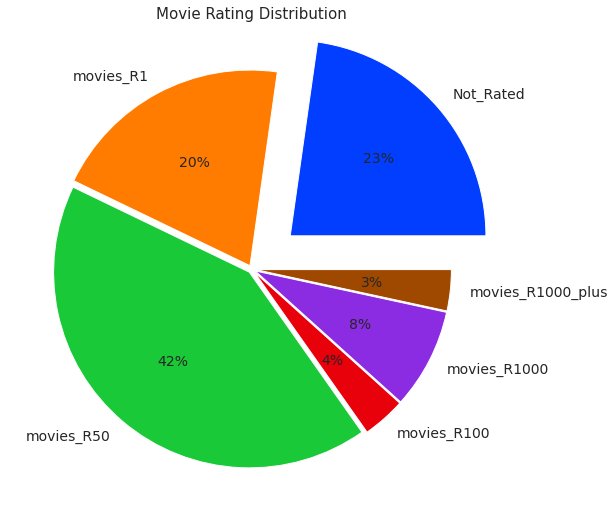

In [ ]:
Not_Rated= []
All_movies= movies_df.movieId.unique()# list of all movies in the dataset
Movies_with_rating= movie_ratings['movieId'].unique() #list of movies with rating 
for movie in All_movies:
  if movie not in Movies_with_rating:
    Not_Rated.append(movie) # Appending list of movies that were not rated at all
Num_of_rate= movie_ratings["movieId"].value_counts().to_frame(name= "num").reset_index() # counting the number of times a movie was rated 
num_of_rate= Num_of_rate.rename(columns={"index":"movieId"})
movies_R1=num_of_rate[num_of_rate["num"]==1]# Movies rated just once 
movies_R50=num_of_rate[(num_of_rate["num"]> 1) & (num_of_rate["num"]<=50)] #movies Rated more than once but less than or equal to 50
movies_R100=num_of_rate[(num_of_rate["num"]>50 ) & (num_of_rate["num"]<=100)] #movies rated more 50 but less than or equal to 100
movies_R1000=num_of_rate[(num_of_rate["num"]> 100) & (num_of_rate["num"]<=1000)] #movies rated more 100 but less than or equal to 1000
movies_R1000_plus =num_of_rate[num_of_rate["num"]>1000] #movies rated more 1000
data = [len(Not_Rated), len(movies_R1), len(movies_R50), len(movies_R100), len(movies_R1000), len(movies_R1000_plus)]
labels = ['Not_Rated', 'movies_R1', 'movies_R50', 'movies_R100', 'movies_R1000', 'movies_R1000_plus']
explode = [0.26,0.02,0.02,0.02,0.02, 0.02]
plt.figure(figsize=(12,9))
colors = sns.color_palette('bright')
plt.pie(data, labels=labels,colors = colors, autopct = '%0.0f%%', explode= explode, textprops={'fontsize': 14})
plt.title("Movie Rating Distribution", fontsize= 15)
plt.show()

Remember , the Movies data set contains 62423 unique movies . The analysis above shows that 23% of the movies were not rated , 20% was rated just once , 42% was rated between 2 to 50 times , 4% was rated 51 to 100 times , 8% was rated 101 to 1000 times and 4% rated was rated more than 1000 times. Therefore a large chunk of movies was not rated at all by the users. 

# How Users Rated Movies (Description )

Let's see how kind the Users rated movies.  what is the most likely rating given to a movie?

Average rating in dataset: 3.5333951730983424


<Figure size 1008x576 with 0 Axes>

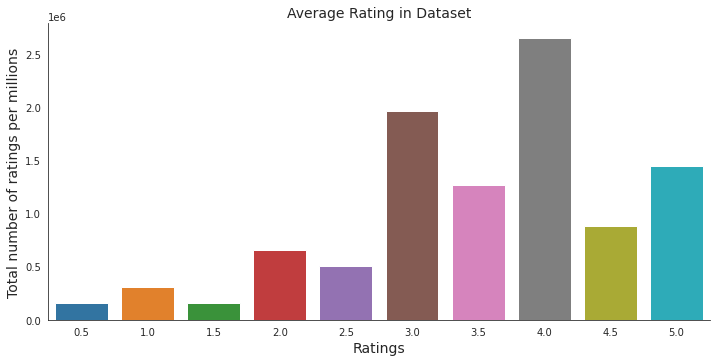

In [ ]:
with sns.axes_style('white'):
    plt.figure(figsize= (14,8))
    g = sns.factorplot("rating", data=movie_ratings, aspect=2.0,kind='count')
    plt.title('Average Rating in Dataset', fontsize=14)
    g.set_xlabels("Ratings", fontsize= 14)
    g.set_ylabels("Total number of ratings per millions", fontsize= 14)
print (f'Average rating in dataset: {np.mean(movie_ratings["rating"])}')
plt.show()

From the above statistic and graphic, we can see that high percentage movie viewers tend to rate movies high. The mean average rating for all the movies is 3.5 while the modal rating(most frequently occuring) rating is 4.0.

#  Number Of Times An individual User Rated a Movie

lets check top 10 users who rated movies the most, top 10 movies with the highest number of rate and last 10 movies with the lowest amount of rates

In [ ]:
Top_10_User= movie_ratings["userId"].value_counts()[0:10]
UserId= Top_10_User.index.tolist()
Num_of_rating= Top_10_User.values.tolist()

Text(0, 0.5, 'Number of Ratings')

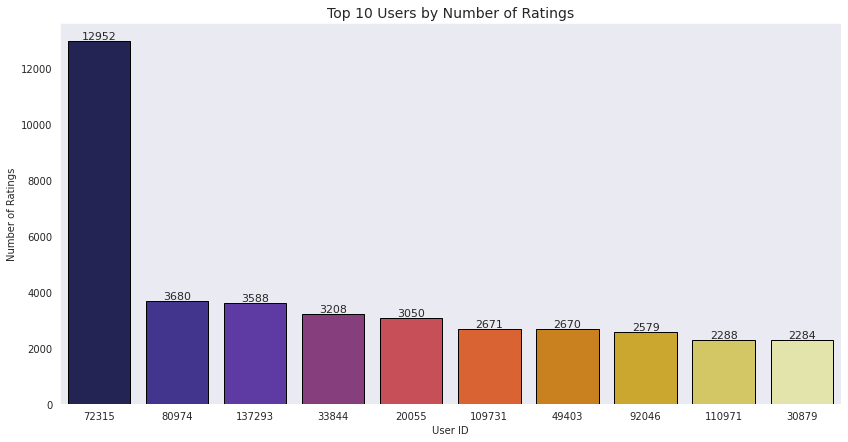

In [ ]:
plt.figure (figsize= (14,7))
ax=sns.barplot(UserId, Num_of_rating, order= UserId, palette='CMRmap', edgecolor="black")
for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
plt.title('Top 10 Users by Number of Ratings', fontsize=14)
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')

This shows the top 10 users who rated movies the most and the number of times the user rated a movie. from the analysis above , User ID 72315 rated movies the most(12952 times ) followed by user ID 80974

In [ ]:
# Create a new dataframe from the train_movies dataframe to get the average rating  
movie_ratings2 = movie_ratings.copy()
Top_movie= movie_ratings2.movieId.value_counts()[0:10] # Getting value count for top 10 rated movies 
movie_Id= Top_movie.index.tolist() #
Num_of_rating= Top_movie.values.tolist()

movie_name=[]
for movie in movie_Id:
  movie_n= movie_ratings[movie_ratings["movieId"]== movie]["title"].unique()[0]
  movie_name.append(movie_n)

# Create a new dataframe from the train_movies dataframe to get the average rating  
Bad_movie= movie_ratings2.movieId.value_counts()[-10:-1]
Bad_movie_Id= Bad_movie.index.tolist()
Num_of_rating_B= Bad_movie.values.tolist()
Bad_movie_name=[]
for movie in Bad_movie_Id:
  movie_n= movie_ratings[movie_ratings["movieId"]== movie]["title"].unique()[0]
  Bad_movie_name.append(movie_n)

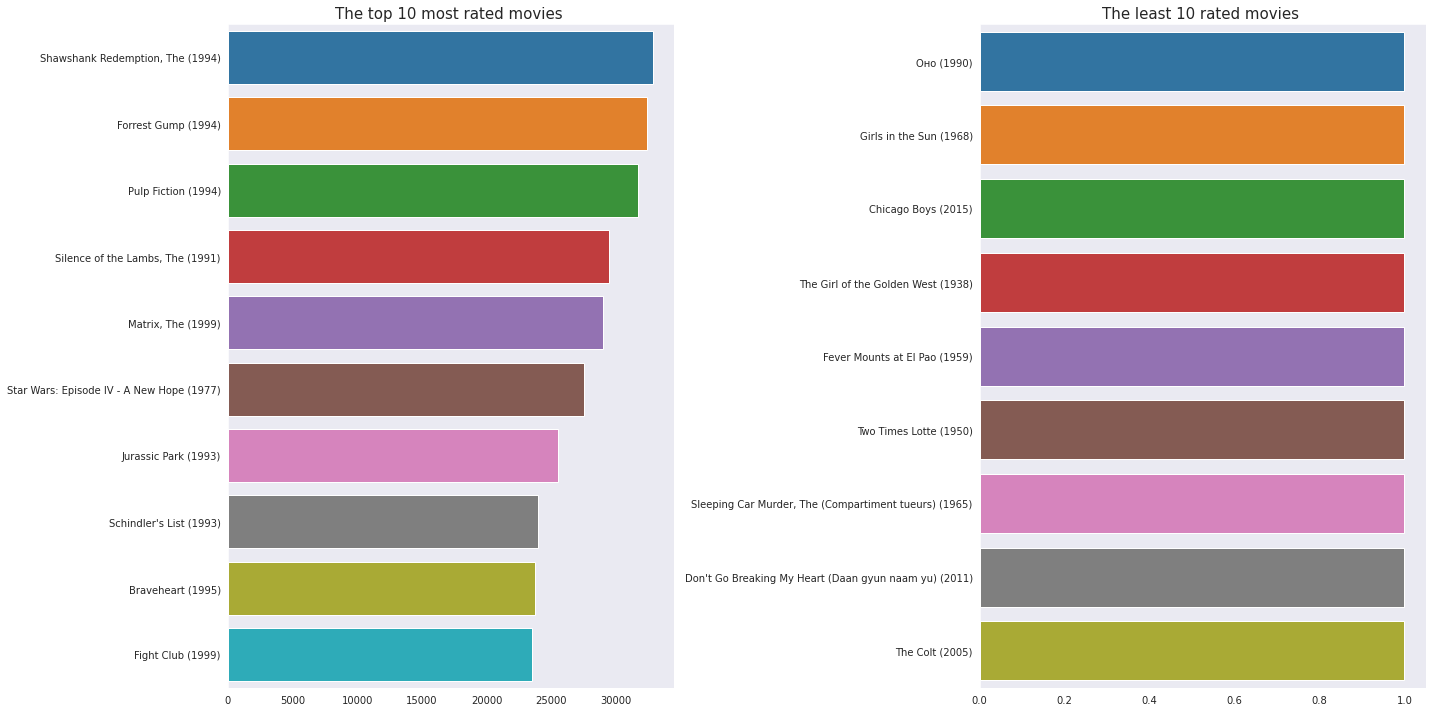

In [ ]:
fig, ax  = plt.subplots(1,2,figsize=(20,10)) # Initialize a figure 

sns.barplot(ax=ax[0], x=Num_of_rating,y =movie_name ) # Create a bar plot of the top 10 movies
ax[0].set_title('The top 10 most rated movies ', fontsize= 15) # Set title of the bar plot 
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation= 90)

sns.barplot(ax=ax[1],x = Num_of_rating_B,y =Bad_movie_name ) # Create a bar plot of the top 10 best rated movies
ax[1].set_title('The least 10 rated movies ', fontsize= 15) # Set title of the bar plot 
fig.tight_layout() # Set layout of the bar subplots 
plt.show() # show the plots 


The visual on the last shows the top most rated movies while the one on the left shows the least 10 rated movies . From the charts, it can be deduced that shawshank redemption is the most reviewed movie, while  ohio is the least reviewed movie   

# How Do Users rate movies based on its genre

In [ ]:
movies_df.head(1)

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","tim,VHS,heart,whimsica,time,Pixar,villian,warm...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,30000000.0,"cowboy,rivalry,animation,cgi,toy",81.0,"tim,heart,whimsica,shawn,time,come,villian,buz..."


In [ ]:
New= [] # empty list to append the movie Id and each genres of the movies 
movie_genre= movies_df[["movieId", 'title', "genres"]] # creating a data frame out of movies_df
 # seperating the genre of each movies by comma and adding it to a seperate segment together with its movie Id
movie_genre["genres"]=movie_genre.genres.apply(lambda x: x.split(','))
for index,row in movie_genre.iterrows():
  for genre in row.genres:
    New.append([getattr(row, "movieId"), genre])

#Creating a dataframe using the New list
Movie_genres= pd.DataFrame(New, columns= ["movieId", "genres"])

In [ ]:
Movie_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


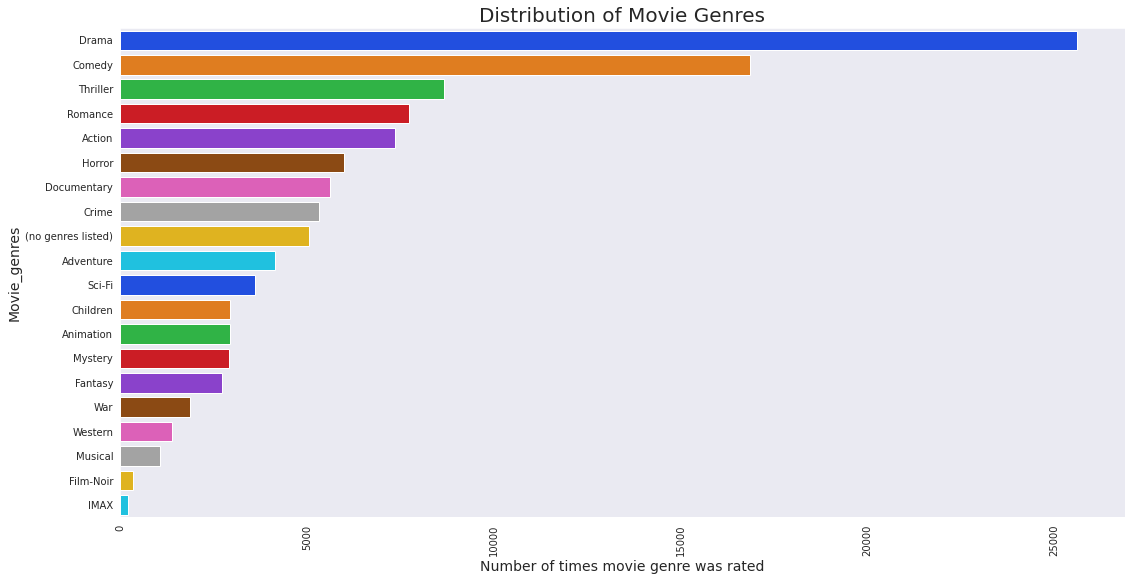

In [ ]:
fig, ax = plt.subplots(figsize=(18, 9))# creating Subplot for visuals and indicating the size
sns.set(font_scale=1.1) # scales of the font
sns.countplot(y='genres' ,data=Movie_genres, order= Movie_genres['genres'].value_counts().index, palette='bright') #Genrating visual using count plot 
plt.xticks(rotation=90)
plt.xlabel('Number of times movie genre was rated', fontsize=14)
plt.ylabel('Movie_genres', size=14)
plt.title('Distribution of Movie Genres', size=20)
plt.show()

From the visual above , This shows that users then to rate Movie that are purely drama in nature, followed by comedy while they least rate movies with Imax genres.

# Movie Production Per year and How people Rate movies Per Year

To better understand the dataset, We need to know how many movies were produced per year , and How people rate those movies 

In [ ]:
All_movie= movies_df[["movieId","title","tags"]] # creating a data frame that contains all movies produced and its title
All_movie["year"]=movies_df['title'].str[-5:-1] # extracting the year 
Movies_prod = All_movie['year'].value_counts()[0:75].sort_index().to_frame().reset_index() # counting numbers of movies that was produced per year and sorting it in descending order.
Movies_prod= Movies_prod.rename(columns= {'index': "year", 'year': "movies_prod"}) # renaming the columns 

In [ ]:
# Quick view of movies produced per year
Movies_prod

,year,movies_prod
0,1937,234
1,1942,257
2,1947,232
3,1948,244
4,1949,265
...,...,...
70,2015,2513
71,2016,2488
72,2017,2374
73,2018,2034


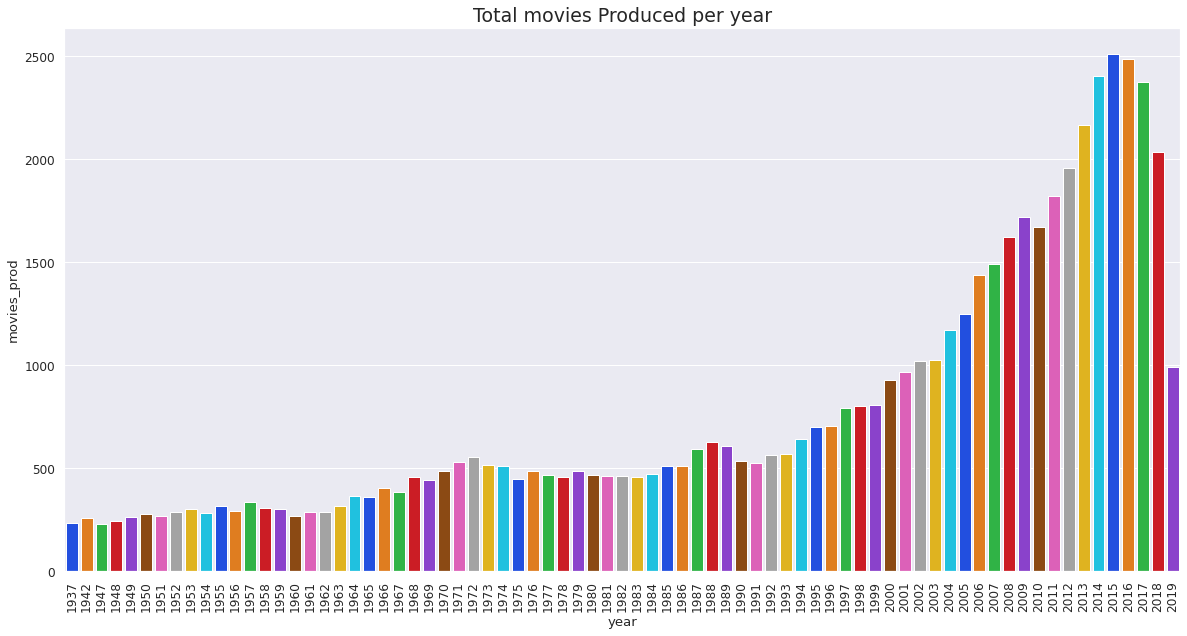

In [ ]:
#Plotting total amount of movies released in each year using a count plot.
figure= plt.subplots(figsize=(20, 10))
axes=sns.barplot(x="year",y= "movies_prod", data= Movies_prod ,palette="bright" )
axes.set_title('Total movies Produced per year',fontsize=19)
plt.xticks(rotation=90)
plt.show()

from the visuals above it can be said that more movies were produce in the early 2000 compared to the 1900 where just little movies were produce. This might be as a result of technological advancement 

Now we need to understand how users rated movies per year

In [ ]:
# Create a copy of the movie_ratings dataframe
movie_rated = movie_ratings.copy()
# Extract release year from movie titles
movie_rated['release_year']=movie_rated['title'].str[-5:-1] #extracting released year
movies_rated = movie_rated['release_year'].value_counts()[0:75].sort_index().to_frame().reset_index()
movies_rated= movies_rated.rename(columns= {'index': "year", 'release_year': "Number_of_rate"})

In [ ]:
movies_rated

,year,Number_of_rate
0,1937,11120
1,1939,23356
2,1940,22906
3,1941,20919
4,1942,18916
...,...,...
70,2015,117610
71,2016,91991
72,2017,68112
73,2018,39278


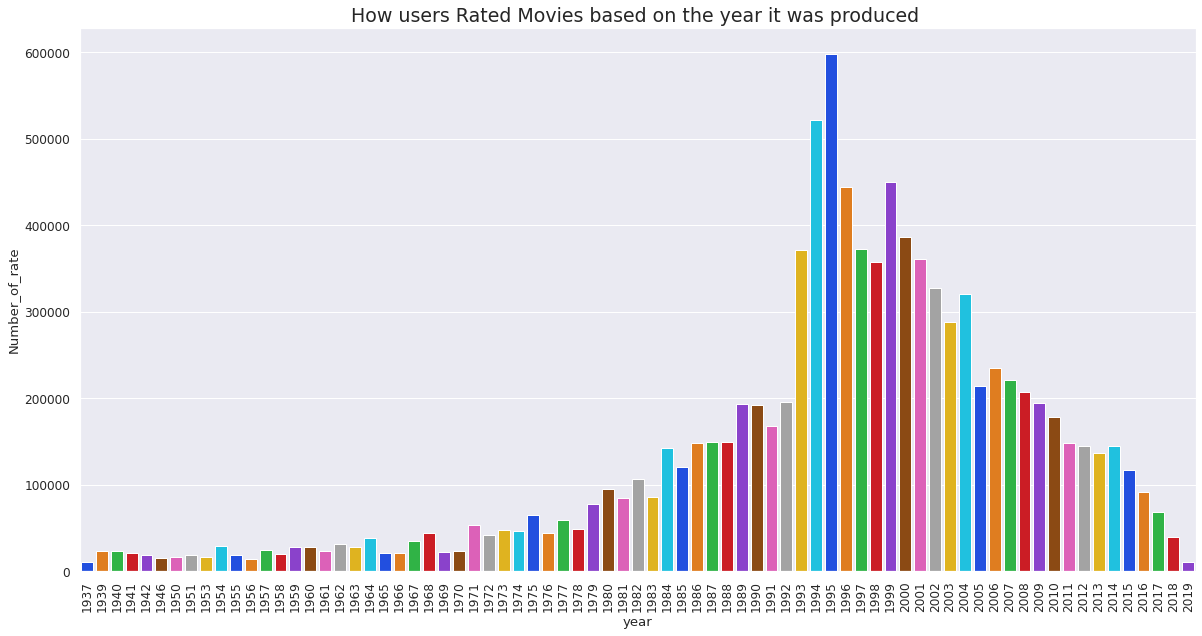

Total Number of Rate since 1900  10000038


In [ ]:
#Plotting total amount of movies released in each year using a count plot.
figure= plt.subplots(figsize=(20, 10))
axes=sns.barplot(x="year",y= "Number_of_rate", data= movies_rated,palette="bright" )
axes.set_title('How users Rated Movies based on the year it was produced ',fontsize=19)
plt.xticks(rotation=90)
plt.show()
print( "Total Number of Rate since 1900 ", len(movie_ratings))

The visual above shows that high amount of rating feedback was received on movies produced in year 1994- 2005.
From the visual, it can be concluded that there was lower numbers of rate feedbacks provided by user on movie pruduced in year 1937- 1992. This might be due to technology incapacitation and visuals. Most users tends to rated only movies with high quality graphics and contents

# Investigating How users rated movies in the 1900"s

Due to lack of availabilty of technology in the 1900 compared to how it is now , we hypothesied that no rating feedback on movies was given by users early 1900"s

In [ ]:
#From movie data, convert timestamp to datetime
movies_ratings['time_dt'] = movies_ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

# # Extract year, month, day, day-of-week Respectively
movies_ratings['Year'] = movies_ratings['time_dt'].dt.year
movies_ratings['Month'] = movies_ratings['time_dt'].dt.month
movies_ratings['Day'] = movies_ratings['time_dt'].dt.day
movies_ratings['Day of Week'] = movies_ratings['time_dt'].dt.dayofweek

In [ ]:
Per_year= movies_ratings.Year. value_counts().to_frame(name= "number_of_Rate").reset_index()
per_year= Per_year.rename(columns= {"index": "year"}).sort_values(by= "year")

In [ ]:
per_year.head()

,year,number_of_Rate
24,1995,1
5,1996,571027
20,1997,250543
23,1998,108811
8,1999,424201


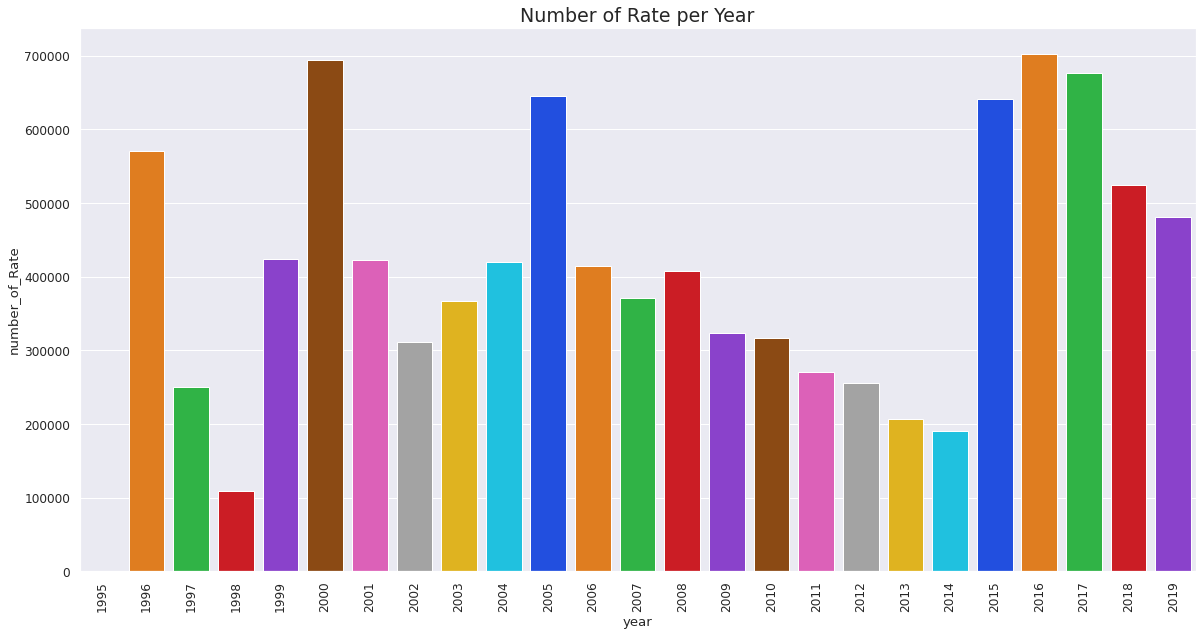

In [ ]:
figure= plt.subplots(figsize=(20, 10))
axes=sns.barplot(x="year",y= "number_of_Rate", data= per_year,palette="bright" )
axes.set_title('Number of Rate per Year',fontsize=19)
plt.xticks(rotation=90)
plt.show()

From the visuals , it is clear that no rating feedback was giving to any movie before 1995 .However one rating was recorded in the year 1995. 2016 recorded the most rating feedbacks. 

# **Most Commonly Used Tags**

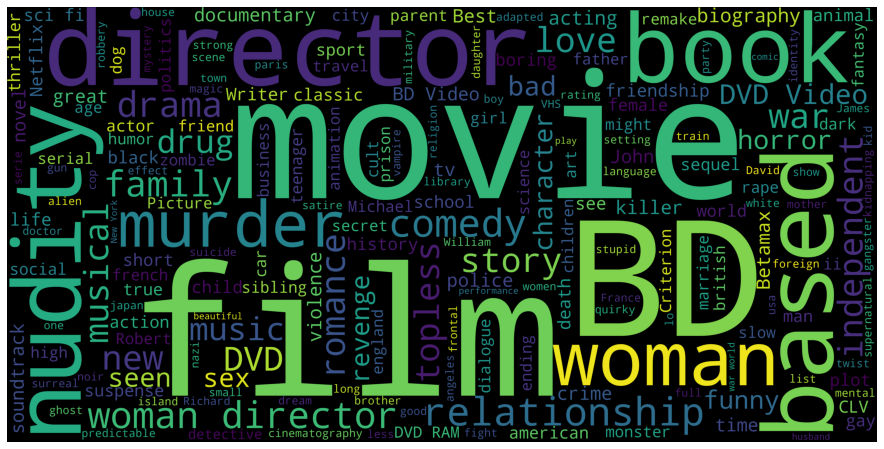

In [ ]:
# Creating a wordcloud of the movie titles to view the most popular movie titles withtin the word cloud
movies_df['tags'] = movies_df['tags'].fillna("").astype('str')
tags_corpus = ' '.join(movies_df['tags'])
tags_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(tags_corpus)

# Plotting the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(tags_wordcloud)
plt.axis('off')
plt.show()

The wordcloud showed that people watched more tag many of the movies with words like comedy, woman, love , murder and police

# **Preprocessing**

## Implementation

We'll now implement a simple content-based filtering prediction system. First, we need to convert all the textual features in the movies_df properties column to numerics through vectorization. The vectorization function we will use is the TF-IDF vectorizer. It counts the frequency of words and their importance. 

In [ ]:
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english', max_features = 10000, ngram_range = (1,2))

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns 
tfidf_matrix = tf.fit_transform(movies_df['properties'])
tfidf_matrix

<62423x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1100628 stored elements in Compressed Sparse Row format>

We now have a sparse matrix with 62423 samples and 15000 features. We now convert the sparse matrix to a dataframe so we can add the budget and runtime columns. They were numeric and could not be passed to the vectorizer. 

In [ ]:
sparse_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
sparse_df

,aaron,aaron new,aasif,abandoned,abandonment,abbas,abbott,abby,abduction,abdul,...,zhou,ziga,zimmer,zo,zoe,zombie,zombies,zone,zoo,zooey
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Prediction

We now do the prediction. The prediction will follow the following steps:

1. We select a given user from the userid and a given movie we need the rating by that user. 
2. Collect the similarity matrix for the reference movie from that user and all other movies that has been rated by that user. 
3. Sort the collected similarity matrix in descending order
4. Select the K-highest similarity values above a given threshhold, thereby creating a k collection. 
5. Compute the weighted average rating, R, for the k-collection. The weighted average is the sum of the similarity values for each movie multiplied by the given user rating, then divided by the sum of the similarity values. When we have the startup problem (the user has not rated any movie at all), then we take the mean of all the ratings given to that movie by the public. 
6. Return the weighted average, R.


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidfg = vectorizer.fit_transform(movies_df["properties"])

In [ ]:
def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [ ]:
def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidfg).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies_df[["movieId","title",'genres']].iloc[indices].iloc[::-1]
    
    return results

In [ ]:
search ("Harry potter")

,movieId,title,genres
53590,187737,A Very Potter Senior Year (2013),Comedy
51605,183507,Voldemort: Origins of the Heir (2018),"Adventure,Drama,Fantasy"
54692,190165,Severus Snape and the Marauders (2016),"Adventure,Drama,Fantasy,Mystery"
7900,8613,"Time of Your Life, The (1948)","Comedy,Drama"
39902,158242,I Ship It (2014),"Comedy,Romance"


In [ ]:
indices

movieId
1             0
2             1
3             2
4             3
5             4
          ...  
209157    62418
209159    62419
209163    62420
209169    62421
209171    62422
Length: 62423, dtype: int64

In [ ]:
userid=5163
movieid=57669 
ref_movie_idx = indices[movieid]
ratings_data=movie_ratings
user_ratings = ratings_data[ratings_data['userId'] == userid][['movieId', 'rating']]
#user_ratings
for ind in user_ratings.index:
        user_movie_idx = indices[user_ratings['movieId'][ind]]
if ref_movie_idx != user_movie_idx:            
            ref_vector = sparse_df.iloc[ref_movie_idx].to_numpy()
ref_vector

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
def estimated_rating(userid, movieid, ratings_data, k=50, threshold = 0.0):
    # convert the movieid to a numeric index for our similarity matrix
    ref_movie_idx = indices[movieid]
    neighbors = [] # our collection of similarity values is stored here
    # Gather the similarity ratings between each movie the user has rated
    # and the reference book
    user_ratings = ratings_data[ratings_data['userId'] == userid][['movieId', 'rating']] # we get a user_ratings dataframe
    # get the index of each rated movie and do the similarity value with the reference movie. Make sure the indices are not the same
    for ind in user_ratings.index:
        user_movie_idx = indices[user_ratings['movieId'][ind]]
        # get the similarity score but check whether we have same index
        # get both vectors
        if ref_movie_idx != user_movie_idx:            
            ref_vector = sparse_df.iloc[ref_movie_idx].to_numpy()
            user_vector = sparse_df.iloc[user_movie_idx].to_numpy()
            sim_score = np.dot(ref_vector, user_vector)/(norm(ref_vector)*norm(user_vector))
            rating = user_ratings['rating'][ind]
            # store sim score and rating as a tuple in neighbors list 
            neighbors.append((sim_score, rating))
    # sort the 50 largest similarity scores
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])
    
    # Compute the weighted average using similarity scores and 
    # user item ratings. 
    simTotal, weightedSum = 0, 0
    for (simScore, rating) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Cold-start problem - No ratings given by user. 
        # We use the average rating for the reference item as a proxy in this case 
        predictedRating = np.mean(ratings_data[ratings_data['movieId']==movieid]['rating'])
    return predictedRating
    
    
    

With our algorithm defined, let's test it out to see some of the results. 

Let's generate a rating for userid = 5163 and movie id = 57669. 

In [ ]:
title = "In Brugges (2008)"
actual_rating = movie_ratings[(movie_ratings['userId'] == 5163) & (movie_ratings['movieId'] == 57669)]['rating'].values[0]
pred_rating = estimated_rating(userid=5163, movieid=57669, ratings_data=movie_ratings)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - In Brugges (2008)
---
Actual rating: 		 4.0
Predicted rating: 	 4.269147572977656


In [ ]:
title = "Father of the Bride Part II (1995)"
actual_rating = movie_ratings[(movie_ratings['userId'] == 106343) & (movie_ratings['movieId'] == 5)]['rating'].values[0]
pred_rating = estimated_rating(userid=106343, movieid=5, ratings_data=movie_ratings)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Father of the Bride Part II (1995)
---
Actual rating: 		 4.5
Predicted rating: 	 3.7073954506082374


This shows us that our algorithm for predicting movie ratings is quite moderately good. We noted that the average rating is about 3.5 across all the movies with a mode of 4.0. So we can say that our rating algorithm is somewhat good overall. 

# **Collaborative Filtering**

The Collaborative filtering method for recommender systems is a method that is solely based on the past interactions that have been recorded between users and items, in order to produce new recommendations.

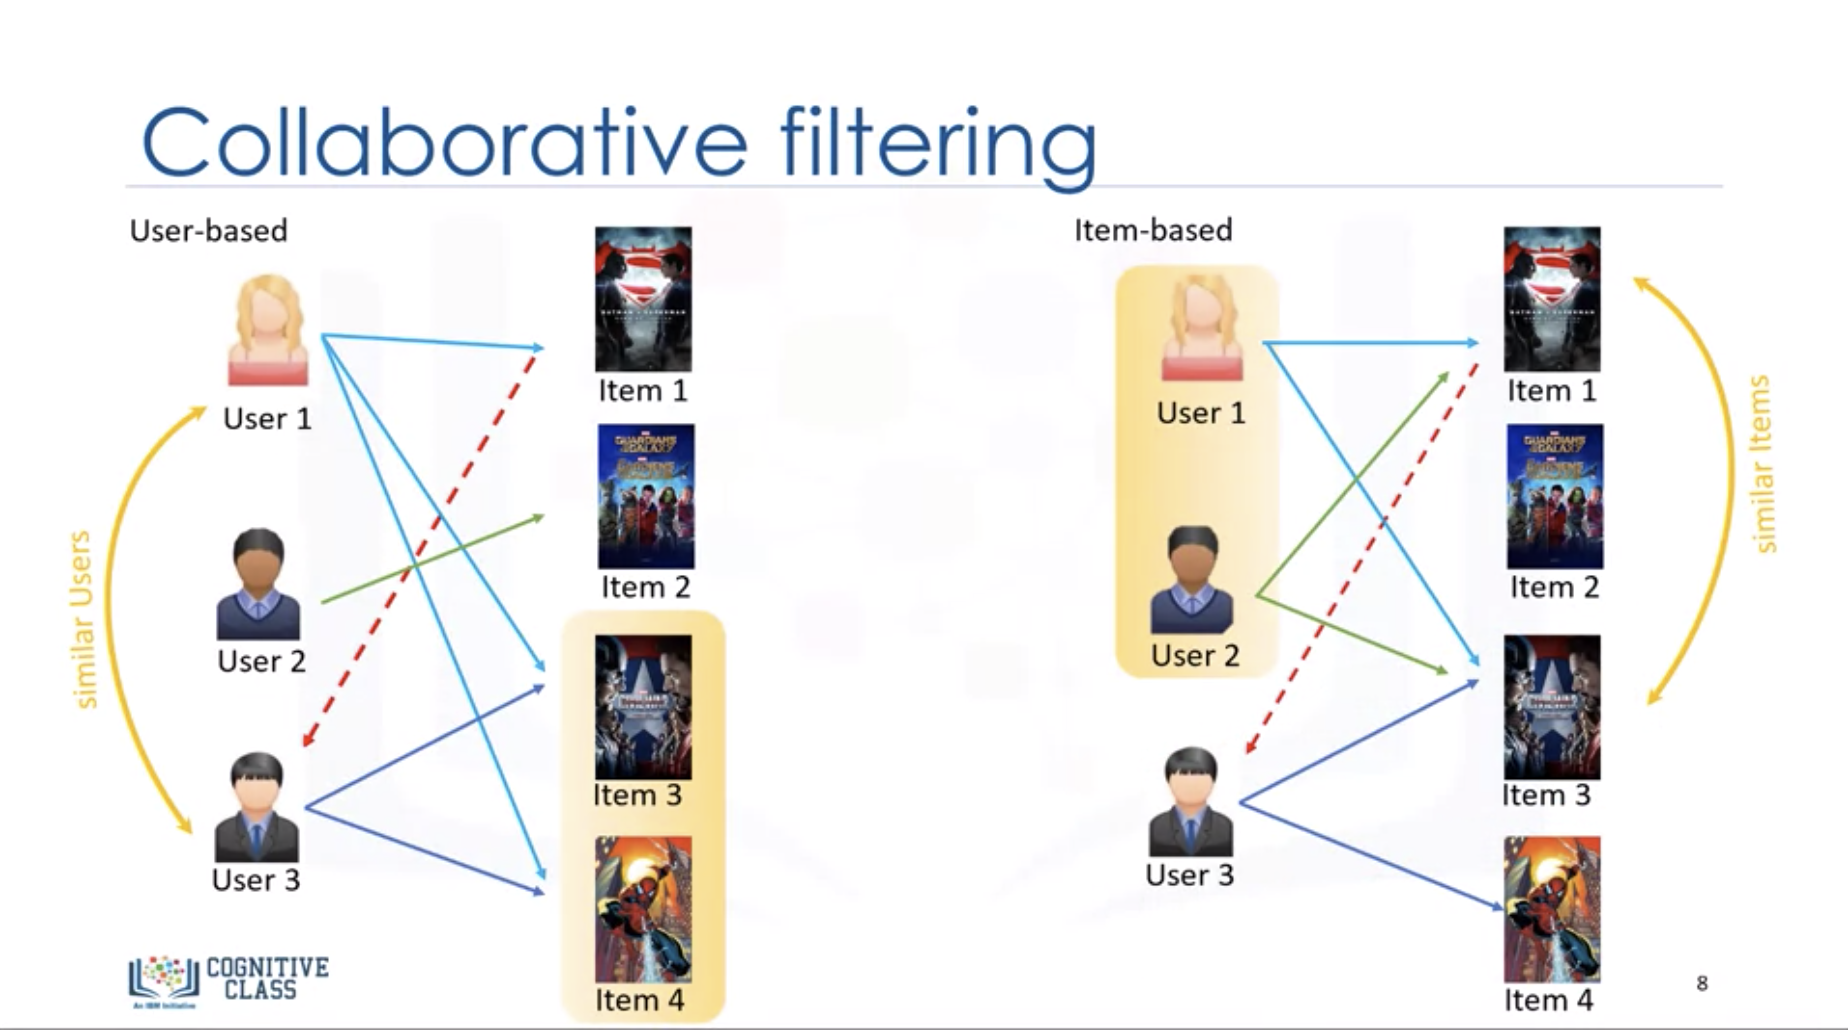

Three types of collaborative filtering commonly used in recommendation systems are neighbor-based, item-to-item and classification- based.

In neighbor-based filtering, users are selected for their similarity to the active user. This similarity is determined by matching users who have posted similar reviews. Based on the previous similarity, it is presumed that future likes and dislikes will also be similar. From the average rating of the group, recommendations are made for the active user.

An item-to-item filtering process uses a matrix to determine the likeness of pairs of items. Item-to-item processes then compare the current user’s preference to the items in the matrix for similarities upon which to base recommendations.

 A classification-based collaborative filtering system recommends things based on how similar users liked that classification or genre. It is assumed that users that enjoy or dislike similar experiences within a classification will also enjoy others within that classification.

Some collaborative filtering systems are memory-based, like neighboring- and item-to-item models, which compare similarities of users or items. Others are model-based, using machine learning to compare dissimilar items. Model-based systems may use algorithms such as the Markov decision process to predict ratings for items that have not yet been reviewed. Hybrid systems include features of both memory-based and model-based filtering

Due to the size and complexity required to train collaborative filtering model on the full data set. We decided to cross-validate on randow samples of the data sets in order to understand how the models would perform. 

In [ ]:
print('Shape of our Actual TRAIN Dataset', movie_ratings.shape) # shape of the original data set 
movie_ratings_small = movie_ratings.sample(frac=0.002, random_state=68) # selecting  randomly selected 2% of the data set.
print('0.2 % of our TRAIN Dataset', movie_ratings_small.shape)# size of our sample

Shape of our Actual TRAIN Dataset (10000038, 4)
0.2 % of our TRAIN Dataset (20000, 4)


We would be training Our data sets on 20000 samples 

## Cross-Validation

In [ ]:
reader = Reader(rating_scale = (0.5,5))
data = Dataset.load_from_df(movie_ratings_small[["userId", "movieId", "rating"]], reader)
result= []
# Iterate over all algorithms

models = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]


for model in models:
    print('loading', str(model))
    # Perform cross validation
    results = cross_validate(model, data, measures=['RMSE'], cv=3, verbose=False)
    print("finishing up", str(model))
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(model).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    result.append(tmp)
    print("Done: " ,str(model), "\n\n")

print ('\n\tDONE\n')

loading <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fcf060c9e90>
finishing up <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fcf060c9e90>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fcf060c9e90> 


loading <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fcef0c1e8d0>
finishing up <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fcef0c1e8d0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fcef0c1e8d0> 


loading <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fceb8675e90>
finishing up <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fceb8675e90>
Done:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fceb8675e90> 


loading <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fceb8675c10>
finishing up <surprise.prediction_algorithms.matrix_factorization.NMF object at 0

In [ ]:
results= pd.DataFrame(result).set_index("Algorithm").sort_values(by = "test_rmse")
results

form the datat frame , we can see that SVDpp produced the best result but due to high computational time required well dealing with large amount of data. Thus we decided to go for the second and third best models (SVD,BaselineOnly) 

# Optimization of Selected Algorithms

### SVD 

In [ ]:
#uncomment to perform gridsearch , This would take place for one hour plus
# param_grid = {'n_epochs': [10, 50 , 60,75, 100], 'lr_all': [0.002, 0.005, 0.01,0.02, 0.04],
#               'reg_all': [0.005, 0.02,0.04,0.1,0.2, 0.4, 0.6], "n_factors": [50,100,150]}
# gs1 = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

In [ ]:
gs1.fit(data)

In [ ]:
best_svd= gs1.best_params

In [ ]:
gs1.best_score

In [ ]:
gs1.predict(testset)

## BaselineOnly

Baselines can be estimated in two different ways:

Using Stochastic Gradient Descent (SGD).
Using Alternating Least Squares (ALS).
You can configure the way baselines are computed using the bsl_options parameter passed at the creation of an algorithm. This parameter is a dictionary for which the key 'method' indicates the method to use. Accepted values are 'als' (default) and 'sgd'. Depending on its value, other options may be set.

In [ ]:
bsl_options_als = {'method': 'als',
               'n_epochs': [5, 20,40,70,80],
               'reg_u': [12,30,50]
               'reg_i': [5,10,30,50]
               }

In [ ]:
bsl_options_sgd= {"method": "sgd"
    "learning_rate": [0.001, 0.002,0.005, 0.006],
   "reg": [0.02, 0.04, 0.06],
   'n_epochs': [20,30,50,75,80]}

In [ ]:
gs2 = GridSearchCV(SVD, bsl_options_als, measures="rmse", cv=3)
als= gs2.fit(data)
gs2.best_score

In [ ]:
gs2.best_params

In [ ]:
gs3= GridSearchCV(SVD, bsl_options_sgd, measures="rmse", cv=3)
sgd= gs3.fit(data)
gs3.best_score

In [ ]:
gs3.best_params

After Optimization, We achieved best result with svd model with parameter {'lr_all': 0.006, 'n_epochs': 75, 'n_factors': 300, 'reg_all': 0.04, "init_std_dev": 0.04} through Gridsearch, Which was able to  produce a better rmse of 1.009

Lets test the best svd on the full data set and see how it performs 

# Optimised Svd on Full Data Set

In [ ]:
#Loading in full movie_df for Modeling
reader = Reader(rating_scale = (0.5,5))
data1 = Dataset.load_from_df(movie_ratings[["userId", "movieId", "rating"]], reader)
trainset, testset = train_test_split(data1, test_size=0.25)

In [ ]:
best_svd= SVD(lr_all= 0.006, n_epochs= 75, n_factors= 300, reg_all= 0.04, init_std_dev= 0.04)

In [ ]:
best_svd.fit(trainset)
b_pred=best_svd.test(testset)

In [ ]:
RMSE= accuracy.rmse(b_pred)
print("Rmse ", RMSE)

WE achieved an RMSE of 0.81 .

# Generating CSV file for kaggle submission

In [ ]:
test["rating"] = test.apply(
    lambda x: best_svd.predict(x["userId"], x["movieId"]).est, axis=1
)
test["Id"] = test.apply(lambda x: f"{x['userId']:.0f}_{x['movieId']:.0f}", axis=1)
submission = test[["Id", "rating"]]

In [ ]:
submission.to_csv("Third.csv", index=False)

# Pickling The Model

In [ ]:
model_save_path = "mlr_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(best_svd,file)

# Model Explaination

Compared to the other Base model model , SVD model was able to produce the best result(rmse) with the least computational time . Svd model operates by decreasing the dimension of the data set by extracting its latent factors and mapping each user and each item into a r-dimensional latent space in order to let the model generalise well and not overfit the training data. Therefore reducing the error between the value predicted by the model and the actual value. Thus producing the best result.

# Conclusion 

Finding and recommending many suitable items that would be liked and selected by users is always a challenge in this modern technology days. Recommendation system provides a way for movie industries to be able to accurately predict what type of movie a user would like and how such movie would be rated. With the development of recommender system , many company have been able to achieve huge success with attracting and retaining users in the movie industry. 

# Reference

[Type of Reccommender systems ](https://www.bluepiit.com/blog/classifying-recommender-systems/#:~:text=%20Classifying%20Different%20Types%20of%20Recommender%20Systems%20,system%20aims%20to%20categorize%20the%20users...%20More%*20*)


[Understanding Movie Recomendation system ](https://www.bing.com/ck/a?!&&p=df40321e922e0ec8JmltdHM9MTY1ODMxMjg3NyZpZ3VpZD1iM2YyZTg3Zi0xYjc5LTQyNTQtODI3Ni1mNzAzOTAyYmIyNzAmaW5zaWQ9NTA5OA&ptn=3&hsh=3&fclid=9f241a16-0816-11ed-9192-5d3922647878&u=a1L3ZpZGVvcy9zZWFyY2g_cT1ob3crdG8rcGVyZm9ybStjb2xsYWJvcmF0aXZlK3JlY2NvbWVuZGVyK3N5c3RlbSZxcHZ0PWhvdyt0bytwZXJmb3JtK2NvbGxhYm9yYXRpdmUrcmVjY29tZW5kZXIrc3lzdGVtJkZPUk09VkRSRQ&ntb=1)